In [ ]:
%pip install imblearn, torch, torchvision, sklearn, numpy > /dev/null 

Note: you may need to restart the kernel to use updated packages.


# IMPORTS

In [2]:
# Imports
import time
import gc
import os

if "torch" not in globals():
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
from torch.optim import AdamW 
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from PIL import Image

from tqdm import tqdm
import csv
import shutil

import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter, defaultdict


# DATA PREPARATIONS

## Defining data paths

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_CUDA_ = torch.cuda.is_available()

print("CUDA: ", _CUDA_)
script_dir = os.getcwd() 

if (_CUDA_):
    script_dir += "/work"
    gc.collect()
    torch.cuda.empty_cache()
    import sys
    sys.path.append(script_dir)

csv_path = os.path.join(script_dir, "Training_set.csv")
train_dir = os.path.join(script_dir, "train")
generated_pth = os.path.join(train_dir, "generated")

img_kern = 150
batch_size = 64

from notifier import notify, send_plot, send_classification_report_as_pdf

notify("🌟🌙✨💫🌌\n🦋🌿🌼🍃🌳\n🌈🦄🦋🍀🌻\n🌊🐚🌴🏝️🍍")

print(f'script dir: {script_dir}\ncsv path: {csv_path}\ntrain dir: {train_dir}\ngenerated dir: {generated_pth}')


CUDA:  True
[telegram] ✅ sendMessage.
script dir: /home/jovyan/work
csv path: /home/jovyan/work/Training_set.csv
train dir: /home/jovyan/work/train
generated dir: /home/jovyan/work/train/generated


In [4]:
import logging
import sys
import errno
from IPython.core.interactiveshell import InteractiveShell

# Настройка логирования
logging.basicConfig(level=logging.ERROR, format="%(asctime)s - %(levelname)s - %(message)s")


def exception_hook(self, etype, value, tb, tb_offset=None):
    """Хук для отправки уведомления при ошибке"""
    if issubclass(etype, KeyboardInterrupt):
        sys.__excepthook__(etype, value, tb)
        notify(etype)
        return []

    # Фильтруем по errno, если это OSError
    if isinstance(value, OSError) and value.errno in errno.errorcode:
        err_name = errno.errorcode[value.errno]
        error_message = f"💥ERR (errno)💥: {err_name} ({value.errno})\n{etype.__name__}: {value}"
    else:
        error_message = f"💥ERR💥:\n{etype.__name__}: {value}"

    # Отправляем сообщение
    notify(error_message)
    logging.error(error_message)
    

    # Возвращаем пустую трассировку, чтобы подавить вывод Jupyter
    return []

# Устанавливаем хук для всех исключений
InteractiveShell.instance().set_custom_exc((BaseException,),  exception_hook)
# sys.excepthook = exception_hook

# Пример ошибки
# raise ValueError("AAAA")


In [5]:
def cleanup():
    to_gb = lambda x: x / (1024 ** 3)  # Преобразование байтов в гигабайты

    mem_before = torch.cuda.memory_reserved()
    print(f"Allocated memory: {to_gb(torch.cuda.memory_allocated()):.2f} GB")

    if (_CUDA_):
        with torch.no_grad():
            torch.cuda.empty_cache()

    gc.collect()

    mem_after = torch.cuda.memory_reserved()
    print(f"Reserved memory: {to_gb(mem_before):.2f} GB -> {to_gb(mem_after):.2f} GB")


## Deliting previously generated images

In [6]:
if os.path.exists(generated_pth):
    for filename in os.listdir(generated_pth):
        file_path = os.path.join(generated_pth, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Удаляет файл или ссылку
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Удаляет папку рекурсивно
        except Exception as e:
            print(f'Не удалось удалить {file_path}. Ошибка: {e}')

cleanup()

Allocated memory: 0.00 GB
Reserved memory: 0.00 GB -> 0.00 GB


## Reading CSVs and creating dictionary with files (filenames, scpecies)

In [7]:
train_data_labels = {}
with open(csv_path, newline='', encoding='utf-8') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        filename, label = row[0], row[1]
        if label not in train_data_labels:
            train_data_labels[label] = []
        train_data_labels[label].append(filename)

species = list(train_data_labels.keys()) 
class_to_idx = {species[i]: i for i in range(len(species))}
print(f'Species count: {len(species)}')
print('Examples: ', species[:5])

Species count: 75
Examples:  ['SOUTHERN DOGFACE', 'ADONIS', 'BROWN SIPROETA', 'MONARCH', 'GREEN CELLED CATTLEHEART']


# DATASET

In [8]:
notify("🥡 DATASET BLOCK")
import copy
class RawDataset(Dataset):
    def __init__(self, data_dict, root_dir, transform=None):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(data_dict.keys())}

        for label, filenames in data_dict.items():
            for filename in filenames:
                img_path = os.path.abspath(os.path.join(root_dir, filename))
                if os.path.exists(img_path):
                    self.data.append(img_path)
                    self.labels.append(self.label_to_idx[label])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def get_class_weights(self):
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(self.labels),
            y=self.labels
        )
        self.class_weights = class_weights
        return torch.tensor(class_weights, dtype=torch.float32)

    def count_labels(self):
        self.label_counts = Counter(self.labels)

    
    def count_medians(self):
        if not self.label_counts:
            self.count_labels()
        return np.median(list(self.label_counts.values()))

    # def update_data(self, new_data, new_labels):
    #     self.data = [x[0] if isinstance(x, (list, np.ndarray)) else x for x in new_data]
    #     self.labels = list(new_labels)
    #     self.count_labels()


    def update_data(self, new_data, new_labels):
        self.data = new_data
        self.labels = new_labels
        self.count_labels()
     

    def copy(self):
        data_dict = defaultdict(list)
    # Получаем имена классов из label_to_idx
        idx_to_label = {v: k for k, v in self.label_to_idx.items()}

        for path, label in zip(self.data, self.labels):
            label_name = idx_to_label[label]
            rel_path = os.path.relpath(path, self.root_dir)
            data_dict[label_name].append(rel_path)

    # Создаем новый экземпляр
        return RawDataset(copy.deepcopy(data_dict), self.root_dir, transform=self.transform)


[telegram] ✅ sendMessage.


In [9]:
class CustomSubset(Subset):
    
    def __init__(self, dataset: RawDataset, indices):
        super().__init__(dataset, indices)
        self.label_counts = Counter([self.dataset.labels[i] for i in self.indices])
    
    def count_labels(self):
        self.label_counts = Counter([self.dataset.labels[i] for i in self.indices])
    

In [10]:
def show_images(dataset, mode="all_classes", target_class_name=None, ncols=10, plot_title=""):
    import math

    assert mode in {"all_classes", "one_class"}, "mode must be 'all_classes' or 'one_class'"

    is_subset = isinstance(dataset, torch.utils.data.Subset)
    images_to_show = []
    labels_to_show = []

    if mode == "all_classes":
        seen_classes = {}
        for i in range(len(dataset)):
            if is_subset:
                image, label = dataset.dataset[dataset.indices[i]]
            else:
                image, label = dataset[i]

            label_int = label.item() if torch.is_tensor(label) else label

            if label_int not in seen_classes:
                seen_classes[label_int] = image

            if len(seen_classes) == len(class_to_idx):
                break

        labels_to_show = list(seen_classes.keys())
        images_to_show = [seen_classes[label] for label in labels_to_show]

    elif mode == "one_class":
        assert target_class_name in class_to_idx, f"Класс '{target_class_name}' не найден в class_to_idx"
        target_label = class_to_idx[target_class_name]

        for i in range(len(dataset)):
            if is_subset:
                image, label = dataset.dataset[dataset.indices[i]]
            else:
                image, label = dataset[i]

            label_int = label.item() if torch.is_tensor(label) else label

            if label_int == target_label:
                images_to_show.append(image)
                labels_to_show.append(label_int)

            if len(images_to_show) >= ncols * 3:  # максимум 3 строки
                break

    # Построение графика
    n = len(images_to_show)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 2, nrows * 2))
    axes = axes.flatten() if nrows > 1 else [axes]

    for i, ax in enumerate(axes):
        if i >= n:
            ax.axis('off')
            continue

        image = images_to_show[i]
        label = labels_to_show[i]

        if isinstance(image, torch.Tensor):
            image = image.detach().cpu().numpy()

        if image.ndim == 3 and image.shape[0] in [1, 3]:
            image = np.transpose(image, (1, 2, 0))
        elif image.ndim == 2:
            pass
        else:
            raise ValueError(f"Unsupported image shape: {image.shape}")

        if image.shape[-1] == 1:
            image = image.squeeze(-1)
            ax.imshow(image, cmap='gray')
        elif image.shape[-1] == 3:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap='gray')

        class_name = list(class_to_idx.keys())[list(class_to_idx.values()).index(label)]
        class_name = class_name.replace(" ", "\n")
        ax.set_title(class_name)
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # fig.subplots_adjust(hspace=0.1, wspace=0.8)
    fig.suptitle(plot_title, fontsize=16)
    plt.show()

    try:
        send_plot(fig, "")
    except Exception as e:
        print("send_plot error:", e)
    cleanup()


In [11]:
# from multiprocessing import Process
def show_images_CPU(dataset, mode="all_classes", target_class_name=None, ncols=10, plot_title=""):
    import threading

    thread = threading.Thread(
    target=show_images, 
    args=(dataset,), 
    kwargs={"mode": mode, "target_class_name": target_class_name,"ncols": ncols, "plot_title": plot_title}
    )
    thread.start()

In [12]:
notify("🥡 init RawDataset")
transform_original = transforms.Compose([
    transforms.Resize((img_kern, img_kern)),
    transforms.ToTensor()
])
dataset = RawDataset(train_data_labels, train_dir, transform=transform_original)
show_images_CPU(dataset, plot_title = "Original images")
original_dataset = dataset.copy()


[telegram] ✅ sendMessage.


[telegram] ✅ sendPhoto.
Allocated memory: 0.00 GB
Reserved memory: 0.00 GB -> 0.00 GB


# UNDERSAMPLING

In [13]:
from imblearn.under_sampling import RandomUnderSampler
import os
import numpy as np
from collections import defaultdict

from imblearn.under_sampling import RandomUnderSampler
import numpy as np

dataset.count_labels()
label_counts = dataset.label_counts
median_count = int(np.median(list(label_counts.values())))

median_strategy = {
    label: median_count
    for label, count in label_counts.items()
    if count > median_count * 1.5
}

def undersample_ds(custom_dataset: RawDataset, strategy):
    
    paths = np.array(custom_dataset.data).reshape(-1, 1)
    labels = np.array(custom_dataset.labels)

    rus = RandomUnderSampler(sampling_strategy=strategy, random_state=42)
    paths_resampled, labels_resampled = rus.fit_resample(paths, labels)
    paths_resampled = [p[0] for p in paths_resampled]

    custom_dataset.update_data(paths_resampled, labels_resampled.tolist())
    print("📉 New label counts:", custom_dataset.label_counts)


raw_images = dataset.copy()
undersample_ds(raw_images, "all")
undersample_ds(dataset, median_strategy)

📉 New label counts: Counter({0: 71, 1: 71, 2: 71, 3: 71, 4: 71, 5: 71, 6: 71, 7: 71, 8: 71, 9: 71, 10: 71, 11: 71, 12: 71, 13: 71, 14: 71, 15: 71, 16: 71, 17: 71, 18: 71, 19: 71, 20: 71, 21: 71, 22: 71, 23: 71, 24: 71, 25: 71, 26: 71, 27: 71, 28: 71, 29: 71, 30: 71, 31: 71, 32: 71, 33: 71, 34: 71, 35: 71, 36: 71, 37: 71, 38: 71, 39: 71, 40: 71, 41: 71, 42: 71, 43: 71, 44: 71, 45: 71, 46: 71, 47: 71, 48: 71, 49: 71, 50: 71, 51: 71, 52: 71, 53: 71, 54: 71, 55: 71, 56: 71, 57: 71, 58: 71, 59: 71, 60: 71, 61: 71, 62: 71, 63: 71, 64: 71, 65: 71, 66: 71, 67: 71, 68: 71, 69: 71, 70: 71, 71: 71, 72: 71, 73: 71, 74: 71})
📉 New label counts: Counter({58: 107, 25: 100, 2: 99, 35: 97, 56: 97, 71: 97, 31: 96, 46: 96, 50: 96, 17: 95, 26: 95, 66: 95, 27: 94, 36: 94, 37: 94, 67: 93, 69: 93, 6: 92, 21: 92, 24: 92, 3: 90, 10: 90, 13: 90, 14: 90, 19: 90, 41: 90, 7: 89, 1: 88, 4: 88, 0: 87, 8: 87, 22: 87, 23: 87, 55: 87, 74: 87, 15: 86, 30: 86, 43: 86, 49: 86, 65: 86, 70: 86, 9: 85, 45: 85, 53: 85, 73: 85

# Random Oversampling

In [14]:
notify("🍄 Counting rare classes")
# Подсчитываем количество примеров для каждого класса

# Получаем медиану или 25-й процентиль
median = max(count for _, count in dataset.label_counts.items())
# Редкие классы будут те, у которых количество примеров меньше медианы
rare_classes = [label for label, count in dataset.label_counts.items() if count < median]
del median
cleanup()
print("Rare classes:", rare_classes)

rare_idx = []
common_idx = []

i = 0
for label in dataset.labels:
    if label in rare_classes:
        rare_idx.append(i)
    else:
        common_idx.append(i)
    i+=1

notify("🍄 Splitting dataset into X, Y")

X = CustomSubset(dataset, rare_idx)
Y = CustomSubset(dataset, common_idx)

original_indices = rare_idx + common_idx  # Индексы всех классов из train_dataset
original_data_dict = train_data_labels

[telegram] ✅ sendMessage.
Allocated memory: 0.00 GB
Reserved memory: 0.00 GB -> 0.00 GB
Rare classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
[telegram] ✅ sendMessage.


##  Data Augmentation for rare classes

In [15]:
notify("🎹 Random Oversampling")

[telegram] ✅ sendMessage.


In [16]:
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

[telegram] ✅ sendMessage.
Allocated memory: 0.00 GB
Reserved memory: 0.00 GB -> 0.00 GB
Allocated memory: 0.00 GB
Reserved memory: 0.00 GB -> 0.00 GB
[telegram] ✅ sendMessage.


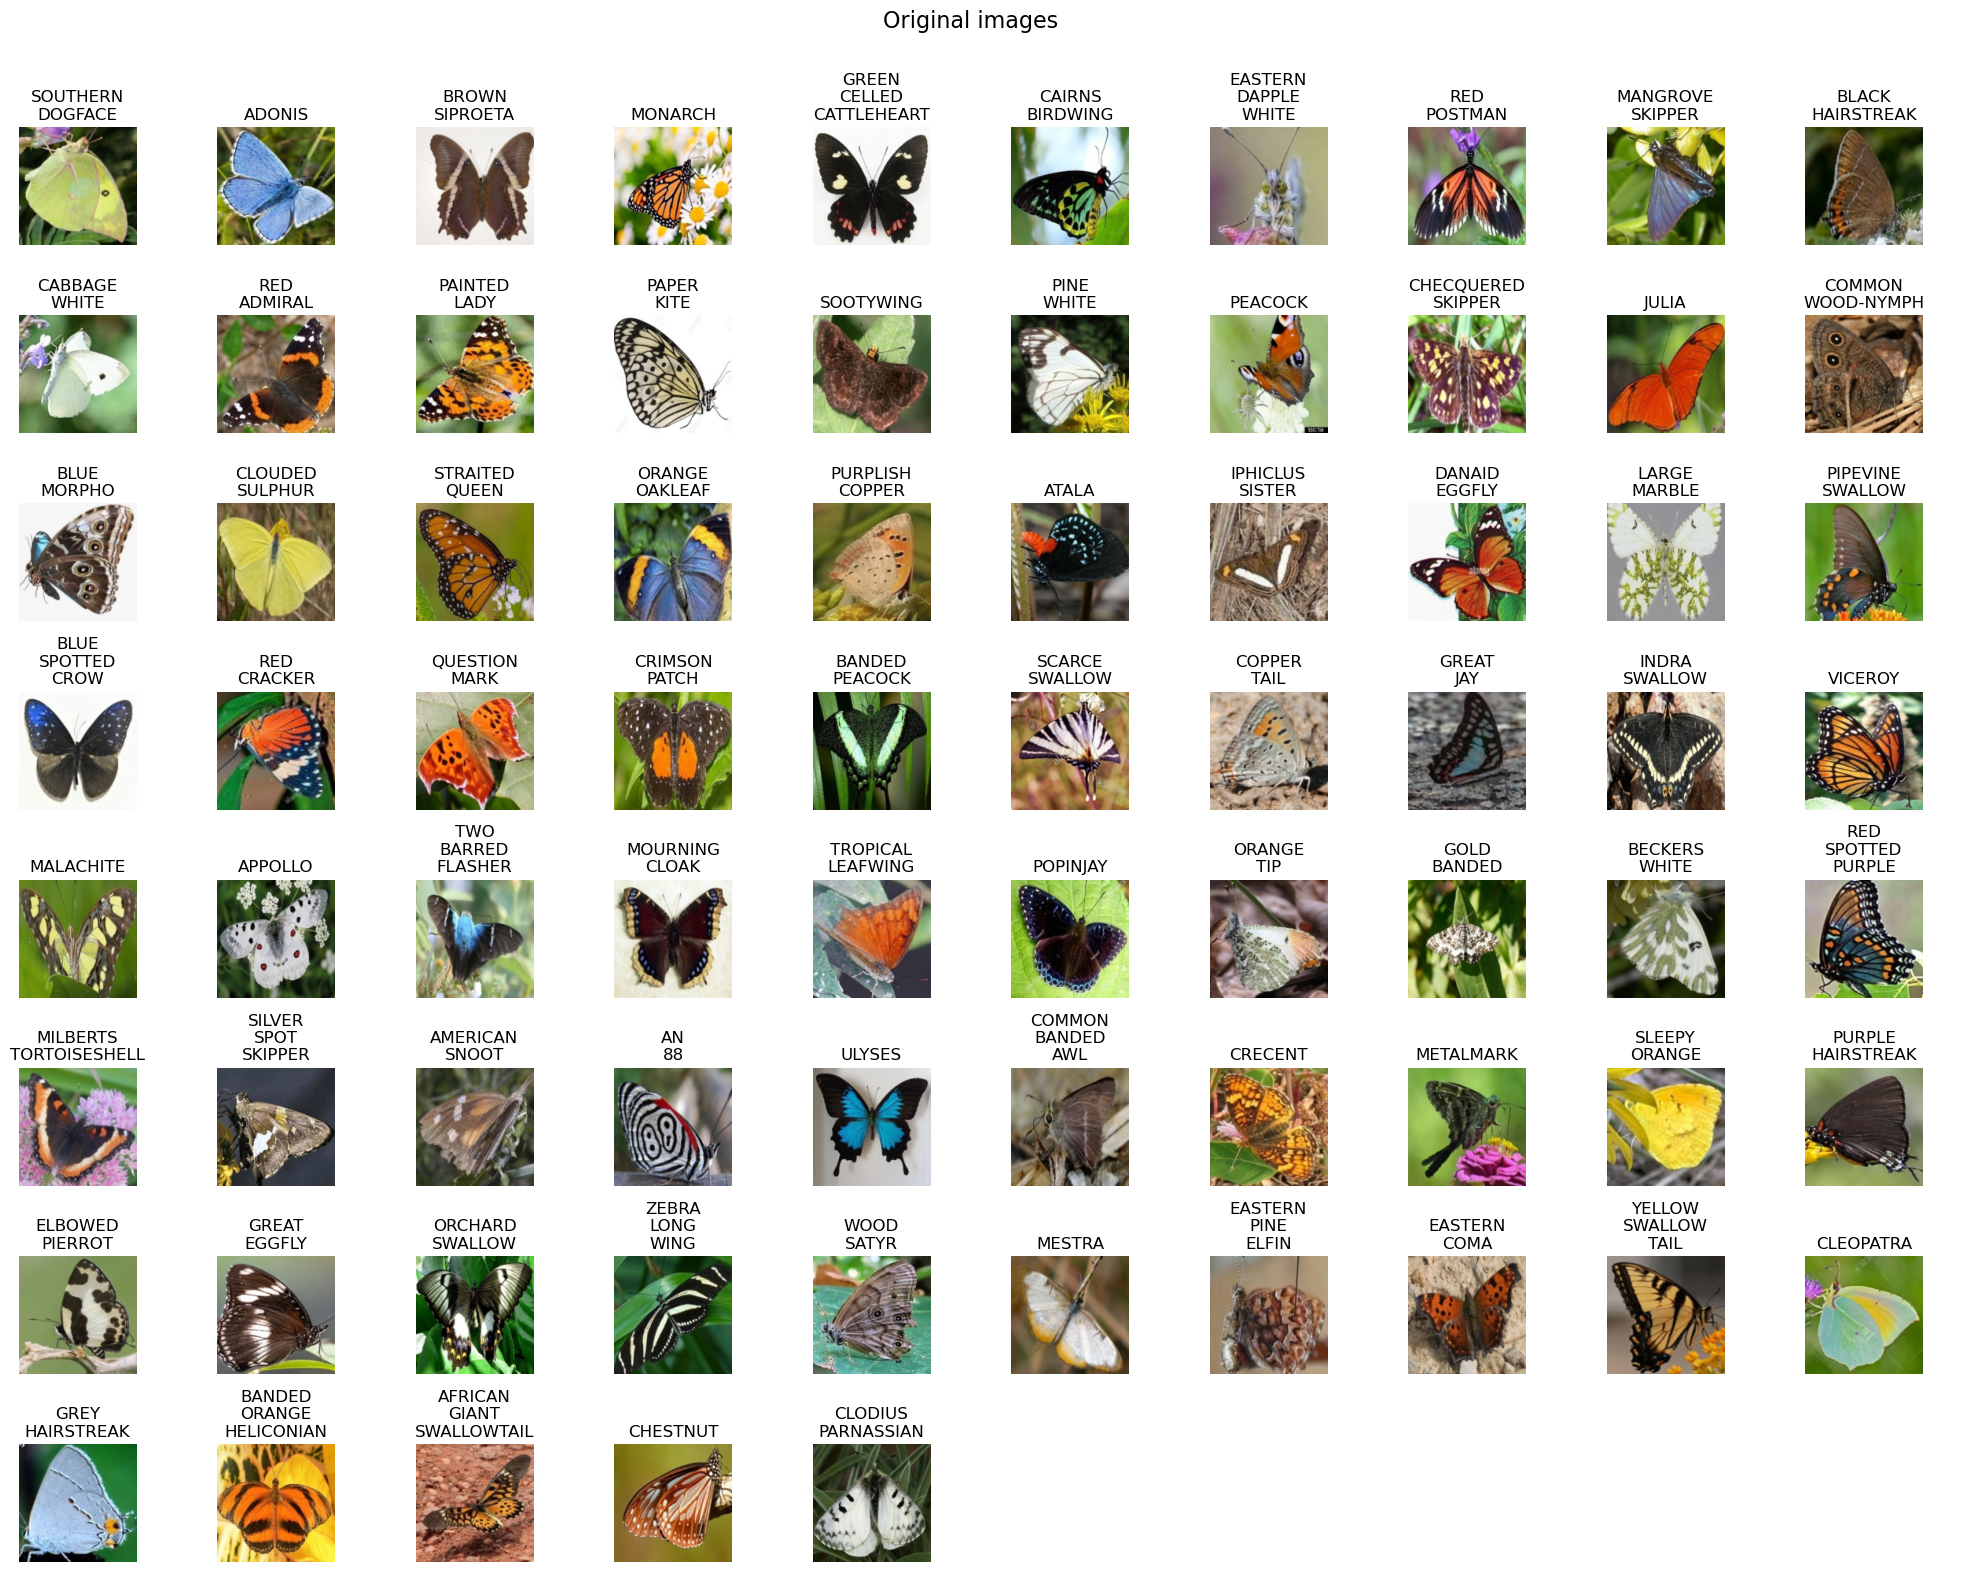

Allocated memory: 0.00 GB
Reserved memory: 0.00 GB -> 0.00 GB
[telegram] ✅ sendMessage.
Allocated memory: 0.00 GB
Reserved memory: 0.00 GB -> 0.00 GB


In [17]:
def get_data_dict_from_subset(subset:CustomSubset, dataset:RawDataset):
    data_dict = defaultdict(list)
    for idx in subset.indices:
        img, label = dataset[idx]
        img = img.numpy()

        if img.ndim == 3:
            img = np.transpose(img, (1, 2, 0))
        elif img.ndim == 2:
            img = np.expand_dims(img, axis=-1)

        img = np.clip(img * 255, 0, 255).astype(np.uint8)
        img_path = os.path.join(generated_pth, f"image_{label}_{len(data_dict[label])}_r.png")
        Image.fromarray(img).save(img_path)
        data_dict[label].append(img_path)
    return data_dict

notify("🎹 🍄 Creating data_dict for Y")

cleanup()
data_dict_Y = get_data_dict_from_subset(Y, dataset)
max_count = max(len(paths) for paths in data_dict_Y.values())
cleanup()
notify("🎹 🍄 Creating data_dict for X")

data_dict_X = get_data_dict_from_subset(X, dataset)
cleanup()

notify("🎹 🍄 Combining dicts")
combined_data_dict = defaultdict(list)
for label in data_dict_Y:
    combined_data_dict[label].extend(data_dict_Y[label])
for label in data_dict_X:
    combined_data_dict[label].extend(data_dict_X[label])

def get_class_counts(data_dict):
    return {cls: len(paths) for cls, paths in data_dict.items()}

combined_counts = get_class_counts(combined_data_dict)

del X, Y
cleanup()

## IMAGE GENERETION

In [18]:
notify("🎹 🏞️ Counting anount of images for each class")
needed_to_generate = {}

for cls in combined_counts:
    current = combined_counts[cls]
    diff = max_count - current
    needed_to_generate[cls] = max(diff, 0)  # если вдруг current < original — не генерим ничего

print("📊 Необходимое количество генераций по классам:")
for cls, count in needed_to_generate.items():
    if (count>0):
        print(f"Класс {cls}: {count} новых изображений")

[telegram] ✅ sendMessage.
📊 Необходимое количество генераций по классам:
Класс 0: 20 новых изображений
Класс 1: 19 новых изображений
Класс 2: 8 новых изображений
Класс 3: 17 новых изображений
Класс 4: 19 новых изображений
Класс 5: 24 новых изображений
Класс 6: 15 новых изображений
Класс 7: 18 новых изображений
Класс 8: 20 новых изображений
Класс 9: 22 новых изображений
Класс 10: 17 новых изображений
Класс 11: 25 новых изображений
Класс 12: 29 новых изображений
Класс 13: 17 новых изображений
Класс 14: 17 новых изображений
Класс 15: 21 новых изображений
Класс 16: 23 новых изображений
Класс 17: 12 новых изображений
Класс 18: 26 новых изображений
Класс 19: 17 новых изображений
Класс 20: 32 новых изображений
Класс 21: 15 новых изображений
Класс 22: 20 новых изображений
Класс 23: 20 новых изображений
Класс 24: 15 новых изображений
Класс 25: 7 новых изображений
Класс 26: 12 новых изображений
Класс 27: 13 новых изображений
Класс 28: 26 новых изображений
Класс 29: 23 новых изображений
Класс 30:

### Generation funcs

In [19]:
def balance_dataset_strict(data_dict, root_dir, output_dir, transform, generation_plan):
    os.makedirs(output_dir, exist_ok=True)
    new_data_dict = {cls: list(paths) for cls, paths in data_dict.items()}
    for cls, n_to_generate in generation_plan.items():
        if n_to_generate <= 0:
            continue

        print(f"🧪 Генерируем {n_to_generate} изображений для класса '{cls}'")
        cls_output_dir = os.path.join(output_dir, str(cls))
        os.makedirs(cls_output_dir, exist_ok=True)

        for i in range(n_to_generate):
            original_path = os.path.join(root_dir, random.choice(data_dict[cls]))
            img = Image.open(original_path).convert("RGB")
            aug_img = transform(img)
            aug_img = transforms.ToPILImage()(aug_img)

            filename = f"aug_{cls}_{i}.jpg"
            aug_path = os.path.join(cls_output_dir, filename)
            aug_img.save(aug_path)

            rel_path = os.path.relpath(aug_path, root_dir)
            new_data_dict[cls].append(rel_path)

    return new_data_dict

notify("🎹 🏞️ Image generation")

balanced_data = balance_dataset_strict(
    data_dict=combined_data_dict,
    root_dir=train_dir,
    output_dir=generated_pth,
    transform=transform_aug,
    generation_plan=needed_to_generate
)

del needed_to_generate, data_dict_X, data_dict_Y
cleanup()

[telegram] ✅ sendMessage.
🧪 Генерируем 20 изображений для класса '0'
🧪 Генерируем 19 изображений для класса '1'
🧪 Генерируем 8 изображений для класса '2'
🧪 Генерируем 17 изображений для класса '3'
🧪 Генерируем 19 изображений для класса '4'
🧪 Генерируем 24 изображений для класса '5'
🧪 Генерируем 15 изображений для класса '6'
🧪 Генерируем 18 изображений для класса '7'
🧪 Генерируем 20 изображений для класса '8'
🧪 Генерируем 22 изображений для класса '9'
🧪 Генерируем 17 изображений для класса '10'
🧪 Генерируем 25 изображений для класса '11'
🧪 Генерируем 29 изображений для класса '12'
🧪 Генерируем 17 изображений для класса '13'
🧪 Генерируем 17 изображений для класса '14'
🧪 Генерируем 21 изображений для класса '15'
🧪 Генерируем 23 изображений для класса '16'
🧪 Генерируем 12 изображений для класса '17'
🧪 Генерируем 26 изображений для класса '18'
🧪 Генерируем 17 изображений для класса '19'
🧪 Генерируем 32 изображений для класса '20'
🧪 Генерируем 15 изображений для класса '21'
🧪 Генерируем 20 и

## Data argumentation

In [20]:
class TransDataset(Dataset):
    def __init__(self, data_dict, root_dir, transform=None):
        self.data = []
        self.labels = []
        self.root_dir = root_dir
        for label, paths in data_dict.items():
            for path in paths:
                self.data.append((os.path.join(root_dir, path), int(label)))
                self.labels.append(int(label))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def copy(self):
        data_dict = defaultdict(list)
        for (path, label) in self.data:
            rel_path = os.path.relpath(path, self.root_dir)
            data_dict[str(label)].append(rel_path)
        return TransDataset(copy.deepcopy(data_dict), self.root_dir, transform=self.transform)
    
    def update_data(self, new_data, new_labels):
        self.data = new_data
        self.labels = new_labels

In [21]:
# Пример: вычисление mean и std
def get_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    nb_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)  # (B, C, H*W)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

# Применение:
mean, std = get_mean_std(dataset)
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4801, 0.4657, 0.3364])
Std: tensor([0.2276, 0.2225, 0.2151])


In [22]:
def mild_color_jitter():
    jitter_range = {
        "brightness": (0.005, 0.02),  
        "contrast":   (0.0, 0.005),
        "saturation": (0.005, 0.01),
        "hue":        (0.001, 0.005)  
    }

    return transforms.ColorJitter(
        brightness=random.uniform(*jitter_range["brightness"]),
        contrast=random.uniform(*jitter_range["contrast"]),
        saturation=random.uniform(*jitter_range["saturation"]),
        hue=random.uniform(*jitter_range["hue"]),
    )

transform_combined = transforms.Compose([
    transforms.Resize((img_kern, img_kern)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomApply([mild_color_jitter()], p=0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [23]:
combined_dataset = TransDataset(balanced_data, train_dir, transform=transform_combined)

In [24]:
show_images_CPU(combined_dataset, plot_title = "Argumented dataset's samples")
target = "ULYSES"
show_images_CPU(combined_dataset, mode="one_class", target_class_name= target,ncols=5,  plot_title= f"{target}'s samples")

[telegram] ✅ sendPhoto.
Allocated memory: 0.06 GB
Reserved memory: 6.64 GB -> 0.14 GB
[telegram] ✅ sendPhoto.
Allocated memory: 0.06 GB
Reserved memory: 6.66 GB -> 0.11 GB


# Class distribution

In [25]:
import matplotlib.pyplot as plt
from collections import Counter

def visualize_dataset_class_distribution(original_dataset, combined_dataset, species):
    """
    Визуализирует распределение классов до и после оверсемплинга.
    
    :param original_dataset: исходный датасет (до оверсемплинга)
    :param combined_dataset: датасет после объединения/оверсемплинга
    :param species: список всех уникальных классов (в том порядке, в котором нужно их отобразить)
    """
    # Получаем метки классов из датасетов
    original_labels = [original_dataset[idx][1] for idx in range(len(original_dataset))]
    combined_labels = [combined_dataset[idx][1] for idx in range(len(combined_dataset))]

    # Подсчёт изображений на класс
    original_counts = Counter(original_labels)
    combined_counts = Counter(combined_labels)

    # Получаем количество по каждому классу из уже известного списка species
    original_class_counts = [original_counts.get(cls, 0) for cls in range(len(species))]
    combined_class_counts = [combined_counts.get(cls, 0) for cls in range(len(species))]

    # Отладочный вывод
    print(f"Original:\n{original_class_counts}\nOversampled:\n{combined_class_counts}")

    # Визуализация

    # Оригинальный датасет
    fig1 = plt.figure(figsize=(10, 6))
    plt.bar(species, original_class_counts, color='#ff9999', alpha=0.8, label='Before Oversampling')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution Before Oversampling')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()  # Убираем обрезание текста
    plt.show()

    send_plot(fig1, 'Before Oversampling')
    cleanup()

    # Комбинированный датасет
    fig2 = plt.figure(figsize=(10, 6))
    plt.bar(species, combined_class_counts, color='#66b3ff', alpha=0.8, label='After Oversampling')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution After Oversampling')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()  # Убираем обрезание текста
    plt.show()

    send_plot(fig2, 'After Oversampling')

    del fig1, fig2
    cleanup()

In [ ]:
from threading import Thread

thread = Thread(target=visualize_dataset_class_distribution,
                args=(original_dataset, combined_dataset, species))
thread.start()

Original:
[87, 88, 99, 90, 88, 83, 92, 89, 87, 85, 90, 82, 78, 90, 90, 86, 84, 95, 81, 90, 75, 92, 87, 87, 92, 100, 95, 94, 81, 84, 86, 96, 77, 72, 83, 97, 94, 94, 81, 81, 73, 90, 76, 131, 83, 85, 96, 73, 81, 86, 96, 83, 74, 85, 84, 87, 97, 76, 107, 79, 82, 78, 76, 76, 71, 86, 95, 93, 75, 93, 86, 97, 75, 85, 87]
Oversampled:
[107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107]
[telegram] ✅ sendPhoto.
Allocated memory: 0.06 GB
Reserved memory: 6.65 GB -> 0.14 GB
[telegram] ✅ sendPhoto.
Allocated memory: 0.06 GB
Reserved memory: 6.66 GB -> 0.11 GB


In [27]:
def split_ds(dataset):
    l = len(dataset)
    train_size = int(0.8 * l)
    test_size = l - train_size
    return random_split(dataset, [train_size, test_size])

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_split(dataset, test_size=0.2, random_state=42):
    """
    Делит датасет на train/test, сохраняя сбалансированность классов.
    
    Работает как с RawDataset, так и TransDataset.
    """
    X = dataset.data
    y = dataset.labels

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(X, y))

    # Получаем train/test данные
    train_data = [X[i] for i in train_idx]
    train_labels = [y[i] for i in train_idx]
    test_data = [X[i] for i in test_idx]
    test_labels = [y[i] for i in test_idx]

    # Копируем и обновляем
    train_set = dataset.copy()
    train_set.update_data(train_data, train_labels)

    test_set = dataset.copy()
    test_set.update_data(test_data, test_labels)

    return train_set, test_set

In [29]:
from torch.utils.data import ConcatDataset

# raw_train, raw_test = split_ds(raw_images)
# comb_train, comb_test = split_ds(combined_dataset)

raw_train, raw_test = stratified_split(raw_images)
comb_train, comb_test = stratified_split(combined_dataset)

train_dataset = ConcatDataset([raw_train, comb_train])
test_dataset = ConcatDataset([raw_test, comb_test])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [30]:
notify("🥡 prepared loaders, datasets")
cleanup()

[telegram] ✅ sendMessage.
Allocated memory: 0.00 GB
Reserved memory: 0.00 GB -> 0.00 GB


In [37]:
print(f"Train samples: {len(train_dataset)},\nTest samples: {len(test_dataset)}")
    # Train samples: 6420,
    # Test samples: 1605

Train samples: 10680,
Test samples: 2670


# NEURAL NETWORK STRUCTURE

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class NeuralNet(nn.Module):
    def __init__(self, num_classes=len(species)):
        super().__init__()

        # 🧠 Свои сверточные слои до EfficientNet
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (B, 3, H, W) -> (B, 32, H, W)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 32, H//2, W//2)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 64, H//4, W//4)
        )

        # Add a layer to reduce the channels to 3
        self.convert_to_3_channels = nn.Conv2d(64, 3, kernel_size=1, padding=0)

        # Загружаем EfficientNet_b0
        from torchvision.models import EfficientNet_B0_Weights

        self.efficientnet_b0 = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

        # Замораживаем веса EfficientNet
        for param in self.efficientnet_b0.parameters():
            param.requires_grad = False

        # Извлекаем все слои кроме классификатора
        self.features = nn.Sequential(*list(self.efficientnet_b0.children())[:-1])

        # Полносвязные слои после feature extractor
        # Полносвязные слои после feature extractor
        self.fc1 = nn.Linear(1280, 2048)  # Было: 512
        self.fc2 = nn.Linear(2048, num_classes)  # Было: 512 -> num_classes
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        # 👣 Пропускаем через свои сверточные блоки
        x = self.conv_block(x)

        # Convert the output to 3 channels
        x = self.convert_to_3_channels(x)

        # ⏩ Подгоняем под EfficientNet
        # EfficientNet ожидает input размером (3, 224, 224), поэтому твой resize в трансформациях должен учитывать это
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        # Пропускаем через EfficientNet
        x = self.features(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

## Function for calculating Neural Net's accuracy (%)

In [39]:
def count_acc(net):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = net(images)
            _, predicted = torch.max(outputs.to(device, non_blocking=True), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    net.train()
    return 100 * correct / total

# LEARNING

## Learning params

In [40]:
net = NeuralNet().to(device)

epoches = 100

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.99, patience=3)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer,
#     max_lr=0.005,
#     steps_per_epoch=len(train_loader),
#     epochs=100,
# )
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)  # Используем ReduceLROnPlateau

train_losses = []
accuracies = []

# Early Stopping параметры
patience = 8  # Количество эпох без улучшения, после которого остановится обучение
best_accuracy = 0
counter = 0

notify("Обучение начато")
cleanup()

start_time = time.time()

[telegram] ✅ sendMessage.
Allocated memory: 0.09 GB
Reserved memory: 6.66 GB -> 0.16 GB


In [41]:
# print(len([label for _, label in train_dataset])) # 6820
# # 5040
# 4978
# 6420

## Learning cycle

In [42]:
for epoch in range(epoches):
    print(f'Epoch {epoch+1}/{epoches}...')
    net.train()
    
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), desc="     train progress", unit="IMG", total=len(train_loader)):
        inputs, labels = data
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs.to(device, non_blocking=True), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'  -> Loss: {avg_loss:4f}')

        # Подсчет accuracy
    accuracy = count_acc(net)
    accuracies.append(accuracy)

    print(f'  -> Accuracy: {accuracy:.2f}%')
    notify(f"🌈 Epoch {epoch+1}/{epoches}...\n-> Loss = {avg_loss:.4f}\n-> Accuracy = {accuracy:.2f}%")

    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        counter = 0  # Сбрасываем счетчик
        torch.save(net.state_dict(), 'best_model.pth')  # Сохраняем лучшую модель
    else:
        counter += 1
        if counter >= patience or accuracy>=95 :
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break  # Останавливаем обучение
    scheduler.step(accuracy)

        # print(torch.cuda.memory_summary())

spent_time = time.time() - start_time
minutes = int(spent_time // 60)
seconds = int(spent_time % 60)

print(f'  -> Time taken: {minutes} min {seconds} sec\n')
torch.save(net.state_dict(), 'trained_net3.pth')

Epoch 1/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 3.186490
  -> Accuracy: 50.22%
[telegram] ✅ sendMessage.
Epoch 2/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 1.916663
  -> Accuracy: 58.58%
[telegram] ✅ sendMessage.
Epoch 3/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.83IMG/s]


  -> Loss: 1.530399
  -> Accuracy: 65.09%
[telegram] ✅ sendMessage.
Epoch 4/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.83IMG/s]


  -> Loss: 1.333188
  -> Accuracy: 66.82%
[telegram] ✅ sendMessage.
Epoch 5/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.84IMG/s]


  -> Loss: 1.211666
  -> Accuracy: 68.09%
[telegram] ✅ sendMessage.
Epoch 6/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 1.119576
  -> Accuracy: 69.51%
[telegram] ✅ sendMessage.
Epoch 7/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 1.045877
  -> Accuracy: 70.26%
[telegram] ✅ sendMessage.
Epoch 8/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.83IMG/s]


  -> Loss: 0.977657
  -> Accuracy: 71.99%
[telegram] ✅ sendMessage.
Epoch 9/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.83IMG/s]


  -> Loss: 0.921101
  -> Accuracy: 71.65%
[telegram] ✅ sendMessage.
Epoch 10/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.84IMG/s]


  -> Loss: 0.866208
  -> Accuracy: 72.06%
[telegram] ✅ sendMessage.
Epoch 11/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.83IMG/s]


  -> Loss: 0.856164
  -> Accuracy: 72.70%
[telegram] ✅ sendMessage.
Epoch 12/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 0.816046
  -> Accuracy: 74.49%
[telegram] ✅ sendMessage.
Epoch 13/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.83IMG/s]


  -> Loss: 0.793623
  -> Accuracy: 75.13%
[telegram] ✅ sendMessage.
Epoch 14/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 0.792228


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.85IMG/s]


  -> Loss: 0.762588
  -> Accuracy: 74.79%
[telegram] ✅ sendMessage.
Epoch 16/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.83IMG/s]


  -> Loss: 0.730916
  -> Accuracy: 76.22%
[telegram] ✅ sendMessage.
Epoch 17/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.83IMG/s]


  -> Loss: 0.723241
  -> Accuracy: 75.43%
[telegram] ✅ sendMessage.
Epoch 18/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 0.712606
  -> Accuracy: 75.84%
[telegram] ✅ sendMessage.
Epoch 19/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.83IMG/s]


  -> Loss: 0.691848
  -> Accuracy: 75.96%
[telegram] ✅ sendMessage.
Epoch 20/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.81IMG/s]


  -> Loss: 0.687122
  -> Accuracy: 76.07%
[telegram] ✅ sendMessage.
Epoch 21/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.83IMG/s]


  -> Loss: 0.672837
  -> Accuracy: 77.45%
[telegram] ✅ sendMessage.
Epoch 22/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 0.664183
  -> Accuracy: 76.55%
[telegram] ✅ sendMessage.
Epoch 23/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.83IMG/s]


  -> Loss: 0.643257
  -> Accuracy: 77.98%
[telegram] ✅ sendMessage.
Epoch 24/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.84IMG/s]


  -> Loss: 0.633880
  -> Accuracy: 77.60%
[telegram] ✅ sendMessage.
Epoch 25/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.84IMG/s]


  -> Loss: 0.620559
  -> Accuracy: 76.85%
[telegram] ✅ sendMessage.
Epoch 26/100...


     train progress:  86%|██████████████████████████████████████████████████▌        | 143/167 [00:50<00:08,  2.81IMG/s]

  -> Accuracy: 76.89%
[telegram] ✅ sendMessage.
Epoch 27/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.83IMG/s]


  -> Loss: 0.613666
  -> Accuracy: 77.72%
[telegram] ✅ sendMessage.
Epoch 28/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 0.619060
  -> Accuracy: 79.25%
[telegram] ✅ sendMessage.
Epoch 29/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 0.575540
  -> Accuracy: 78.99%
[telegram] ✅ sendMessage.
Epoch 30/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.85IMG/s]


  -> Loss: 0.610985
  -> Accuracy: 77.94%
[telegram] ✅ sendMessage.
Epoch 31/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.85IMG/s]


  -> Loss: 0.600042
  -> Accuracy: 79.25%
[telegram] ✅ sendMessage.
Epoch 32/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.83IMG/s]


  -> Loss: 0.573977
  -> Accuracy: 79.40%
[telegram] ✅ sendMessage.
Epoch 33/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 0.579533
  -> Accuracy: 79.63%
[telegram] ✅ sendMessage.
Epoch 34/100...


     train progress:  72%|██████████████████████████████████████████▋                | 121/167 [00:42<00:16,  2.83IMG/s]

  -> Accuracy: 79.36%
[telegram] ✅ sendMessage.
Epoch 35/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.83IMG/s]


  -> Loss: 0.586838
  -> Accuracy: 79.59%
[telegram] ✅ sendMessage.
Epoch 36/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.84IMG/s]


  -> Loss: 0.551626
  -> Accuracy: 79.89%
[telegram] ✅ sendMessage.
Epoch 37/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 0.569862
  -> Accuracy: 78.43%
[telegram] ✅ sendMessage.
Epoch 38/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.84IMG/s]


  -> Loss: 0.547120
  -> Accuracy: 79.25%
[telegram] ✅ sendMessage.
Epoch 39/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.83IMG/s]


  -> Loss: 0.550434
  -> Accuracy: 79.55%
[telegram] ✅ sendMessage.
Epoch 40/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.83IMG/s]


  -> Loss: 0.558913
  -> Accuracy: 79.33%
[telegram] ✅ sendMessage.
Epoch 41/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 0.532092
  -> Accuracy: 79.29%
[telegram] ✅ sendMessage.
Epoch 42/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.82IMG/s]


  -> Loss: 0.524061
  -> Accuracy: 79.48%
[telegram] ✅ sendMessage.
Epoch 43/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:58<00:00,  2.84IMG/s]


  -> Loss: 0.554465
  -> Accuracy: 79.63%
[telegram] ✅ sendMessage.
Epoch 44/100...


     train progress: 100%|███████████████████████████████████████████████████████████| 167/167 [00:59<00:00,  2.81IMG/s]


  -> Loss: 0.517453
  -> Accuracy: 79.89%
[telegram] ✅ sendMessage.
Early stopping triggered after 44 epochs!
  -> Time taken: 51 min 57 sec



In [43]:
notify(f"LEARNING IS COMPELE ✅\nAccuracy = {best_accuracy:.2f}%\nTime taken: {minutes} min {seconds} sec")
del net
cleanup()
net = NeuralNet().to(device)
net.load_state_dict(torch.load('best_model.pth', map_location=device))
net.eval()

[telegram] ✅ sendMessage.
Allocated memory: 0.09 GB
Reserved memory: 6.67 GB -> 0.14 GB


NeuralNet(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convert_to_3_channels): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
  (efficientnet_b0): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0):

# RESULTS

In [44]:
thread = Thread(target=visualize_dataset_class_distribution,
                args=(combined_dataset, train_dataset, species))
thread.start()

Original:
[107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107]
Oversampled:
[143, 141, 141, 143, 143, 143, 143, 143, 143, 143, 143, 142, 143, 143, 141, 142, 143, 143, 143, 143, 141, 141, 143, 141, 142, 143, 142, 142, 143, 141, 143, 143, 142, 143, 143, 143, 143, 141, 143, 143, 143, 142, 143, 142, 143, 143, 142, 143, 142, 143, 143, 141, 141, 143, 143, 142, 143, 142, 143, 141, 141, 143, 143, 143, 143, 141, 143, 142, 142, 143, 141, 141, 143, 142, 143]
[telegram] ✅ sendPhoto.
Allocated memory: 0.10 GB
Reserved memory: 0.13 GB -> 0.13 GB
[telegram] ✅ sendPhoto.
Allocated memory: 0.10 GB
Reserved memory: 0.13 GB -> 0.13 GB


In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(net, dataloader, class_names):
    net.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("🧾 Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(class_names)
    print(set(all_labels))
    fig = plt.figure(figsize=(20, 15))
    sns.heatmap(
        cm,
        annot=False,  # ❌ Без чисел
        cmap="flare",  # 🎨 Цвета
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    send_plot(fig, "Classes distribution")
    del fig
    cleanup()
    
    send_classification_report_as_pdf(report)

    return report


📊 Финальная оценка модели:
🧾 Classification Report:
                            precision    recall  f1-score   support

         SOUTHERN DOGFACE       0.73      0.69      0.71        35
                   ADONIS       0.91      0.86      0.89        37
           BROWN SIPROETA       0.84      0.84      0.84        37
                  MONARCH       0.65      0.86      0.74        35
 GREEN CELLED CATTLEHEART       0.80      0.91      0.85        35
          CAIRNS BIRDWING       1.00      0.86      0.92        35
     EASTERN DAPPLE WHITE       0.65      0.49      0.56        35
              RED POSTMAN       0.77      0.77      0.77        35
         MANGROVE SKIPPER       0.72      0.74      0.73        35
         BLACK HAIRSTREAK       0.84      0.89      0.86        35
            CABBAGE WHITE       0.91      0.91      0.91        35
              RED ADMIRAL       0.84      0.86      0.85        36
             PAINTED LADY       0.83      0.83      0.83        35
        

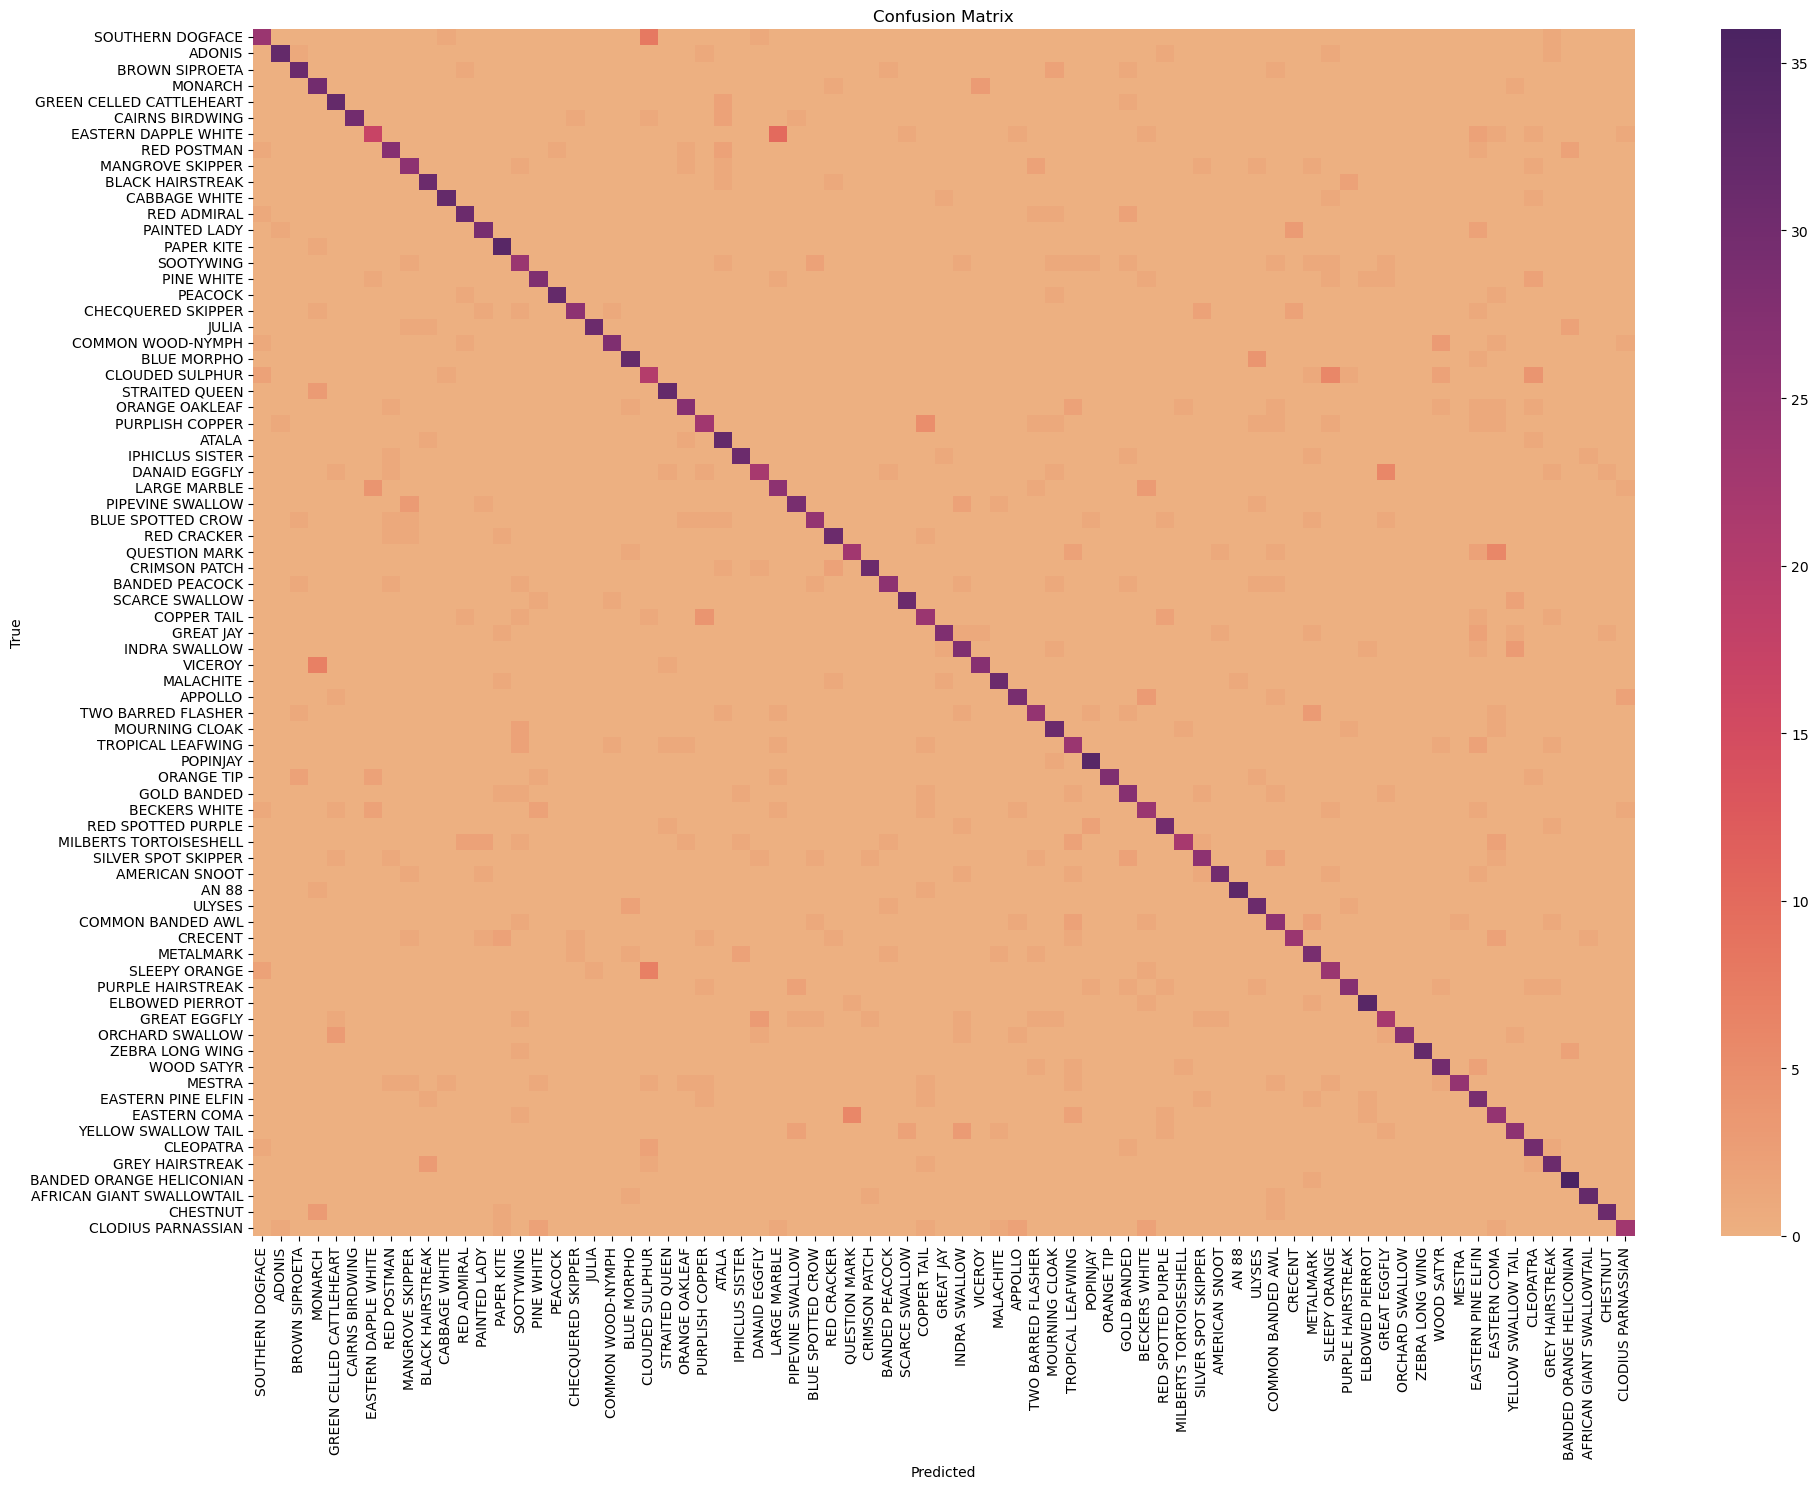

[telegram] ✅ sendPhoto.
Allocated memory: 0.11 GB
Reserved memory: 1.19 GB -> 0.15 GB
[telegram] ✅ sendDocument.
Allocated memory: 0.10 GB
Reserved memory: 0.15 GB -> 0.13 GB


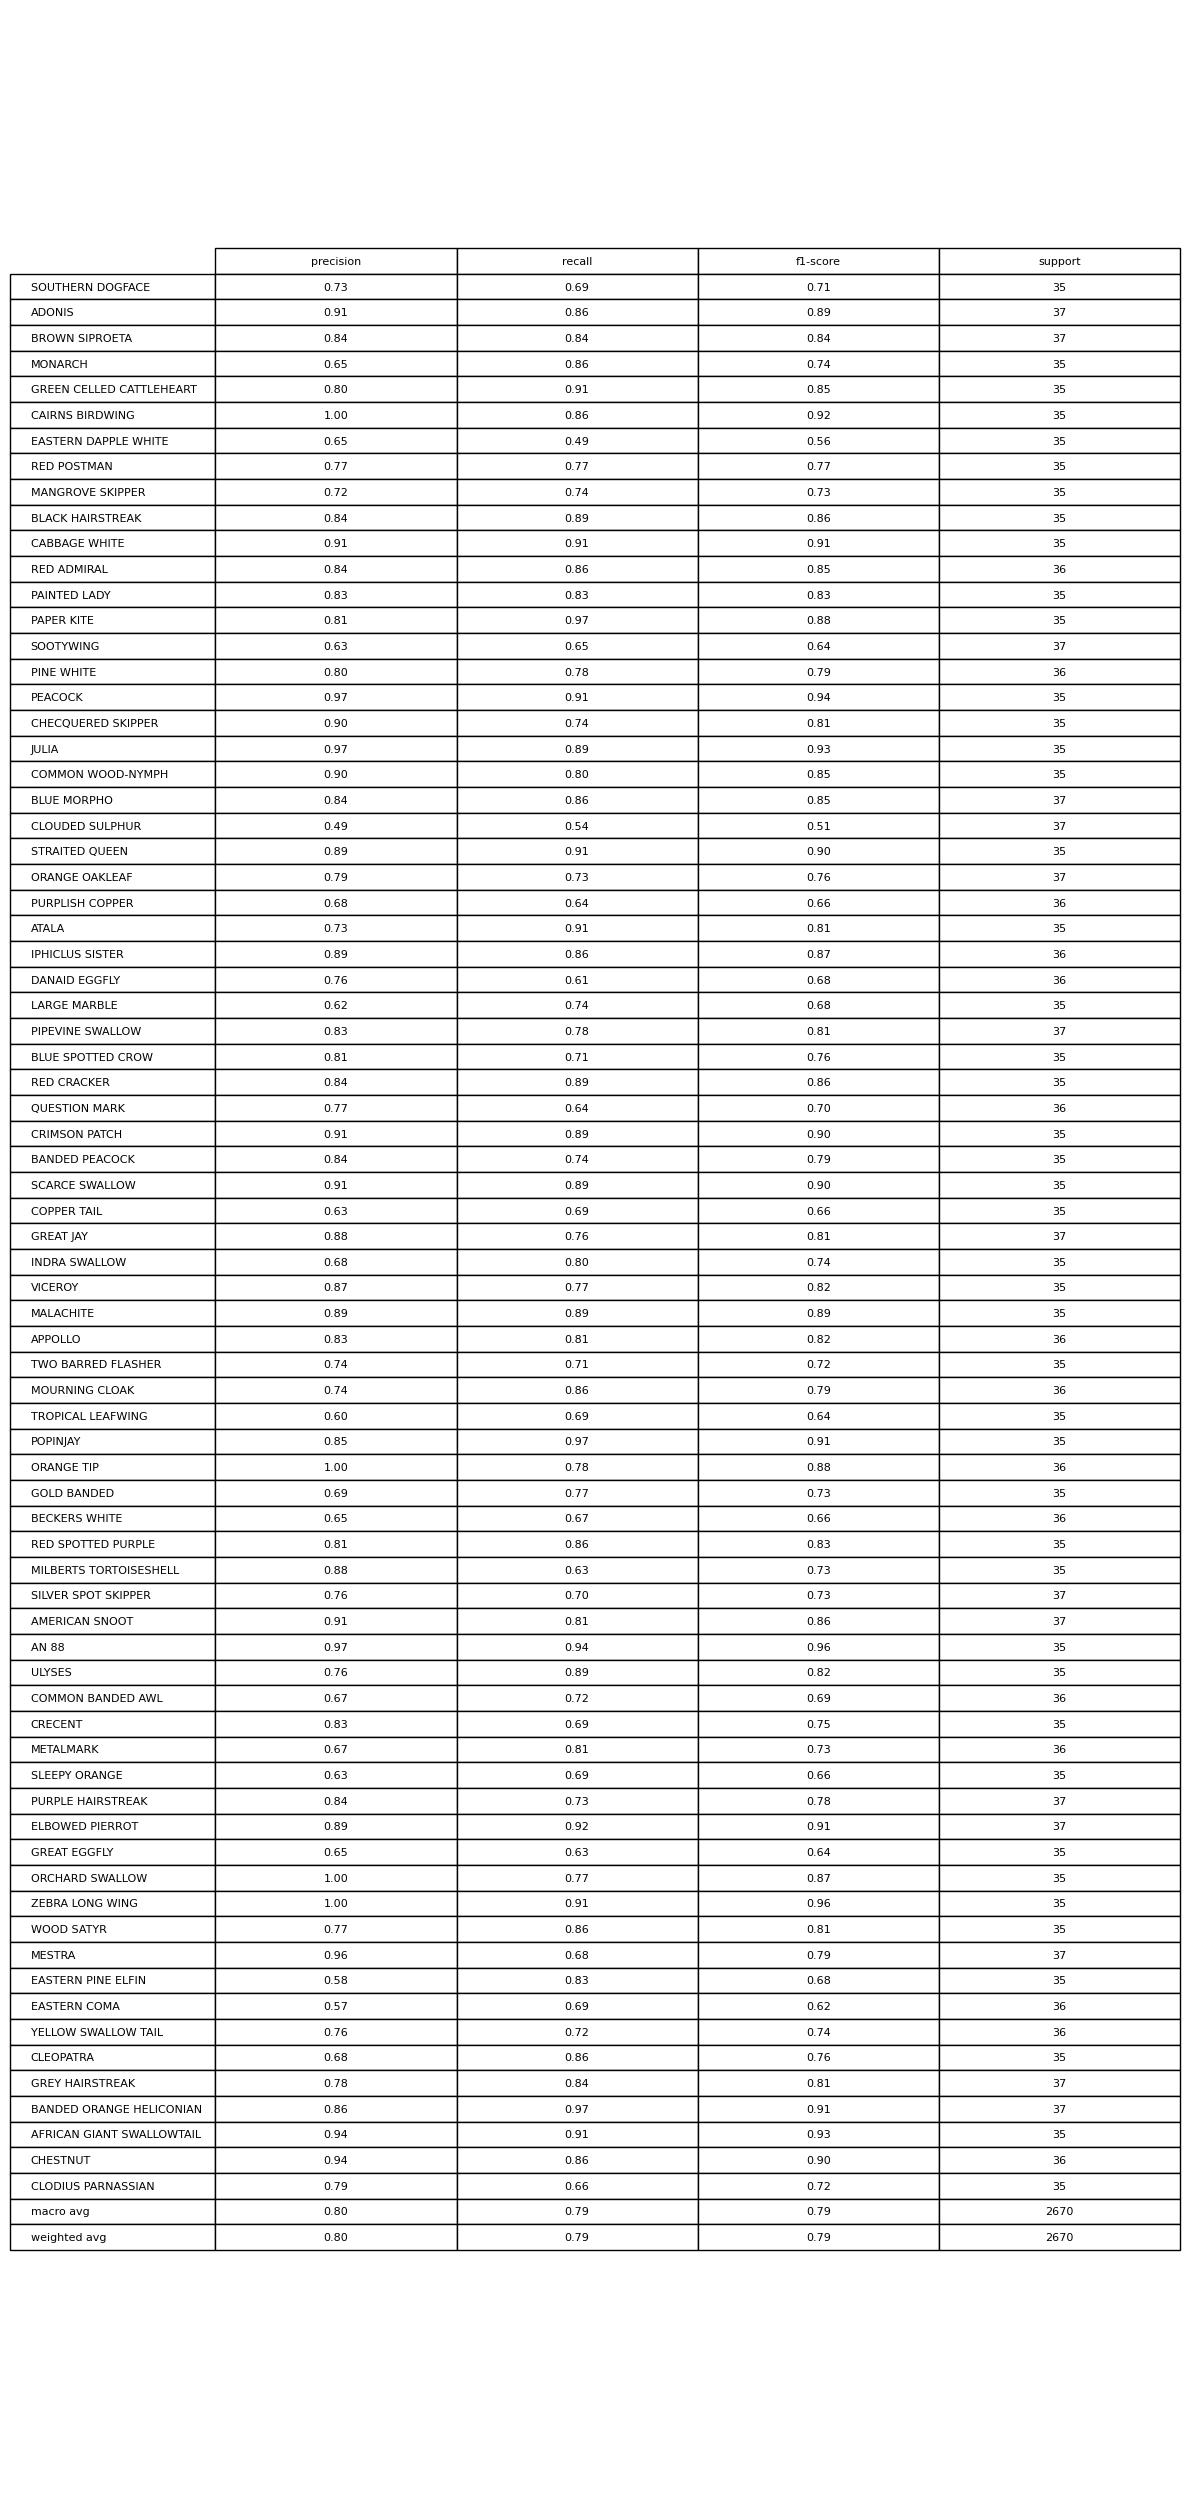

In [46]:
print("📊 Финальная оценка модели:")
evaluate_model(net, test_loader, species)
cleanup()

## Learning spine

[telegram] ✅ sendPhoto.


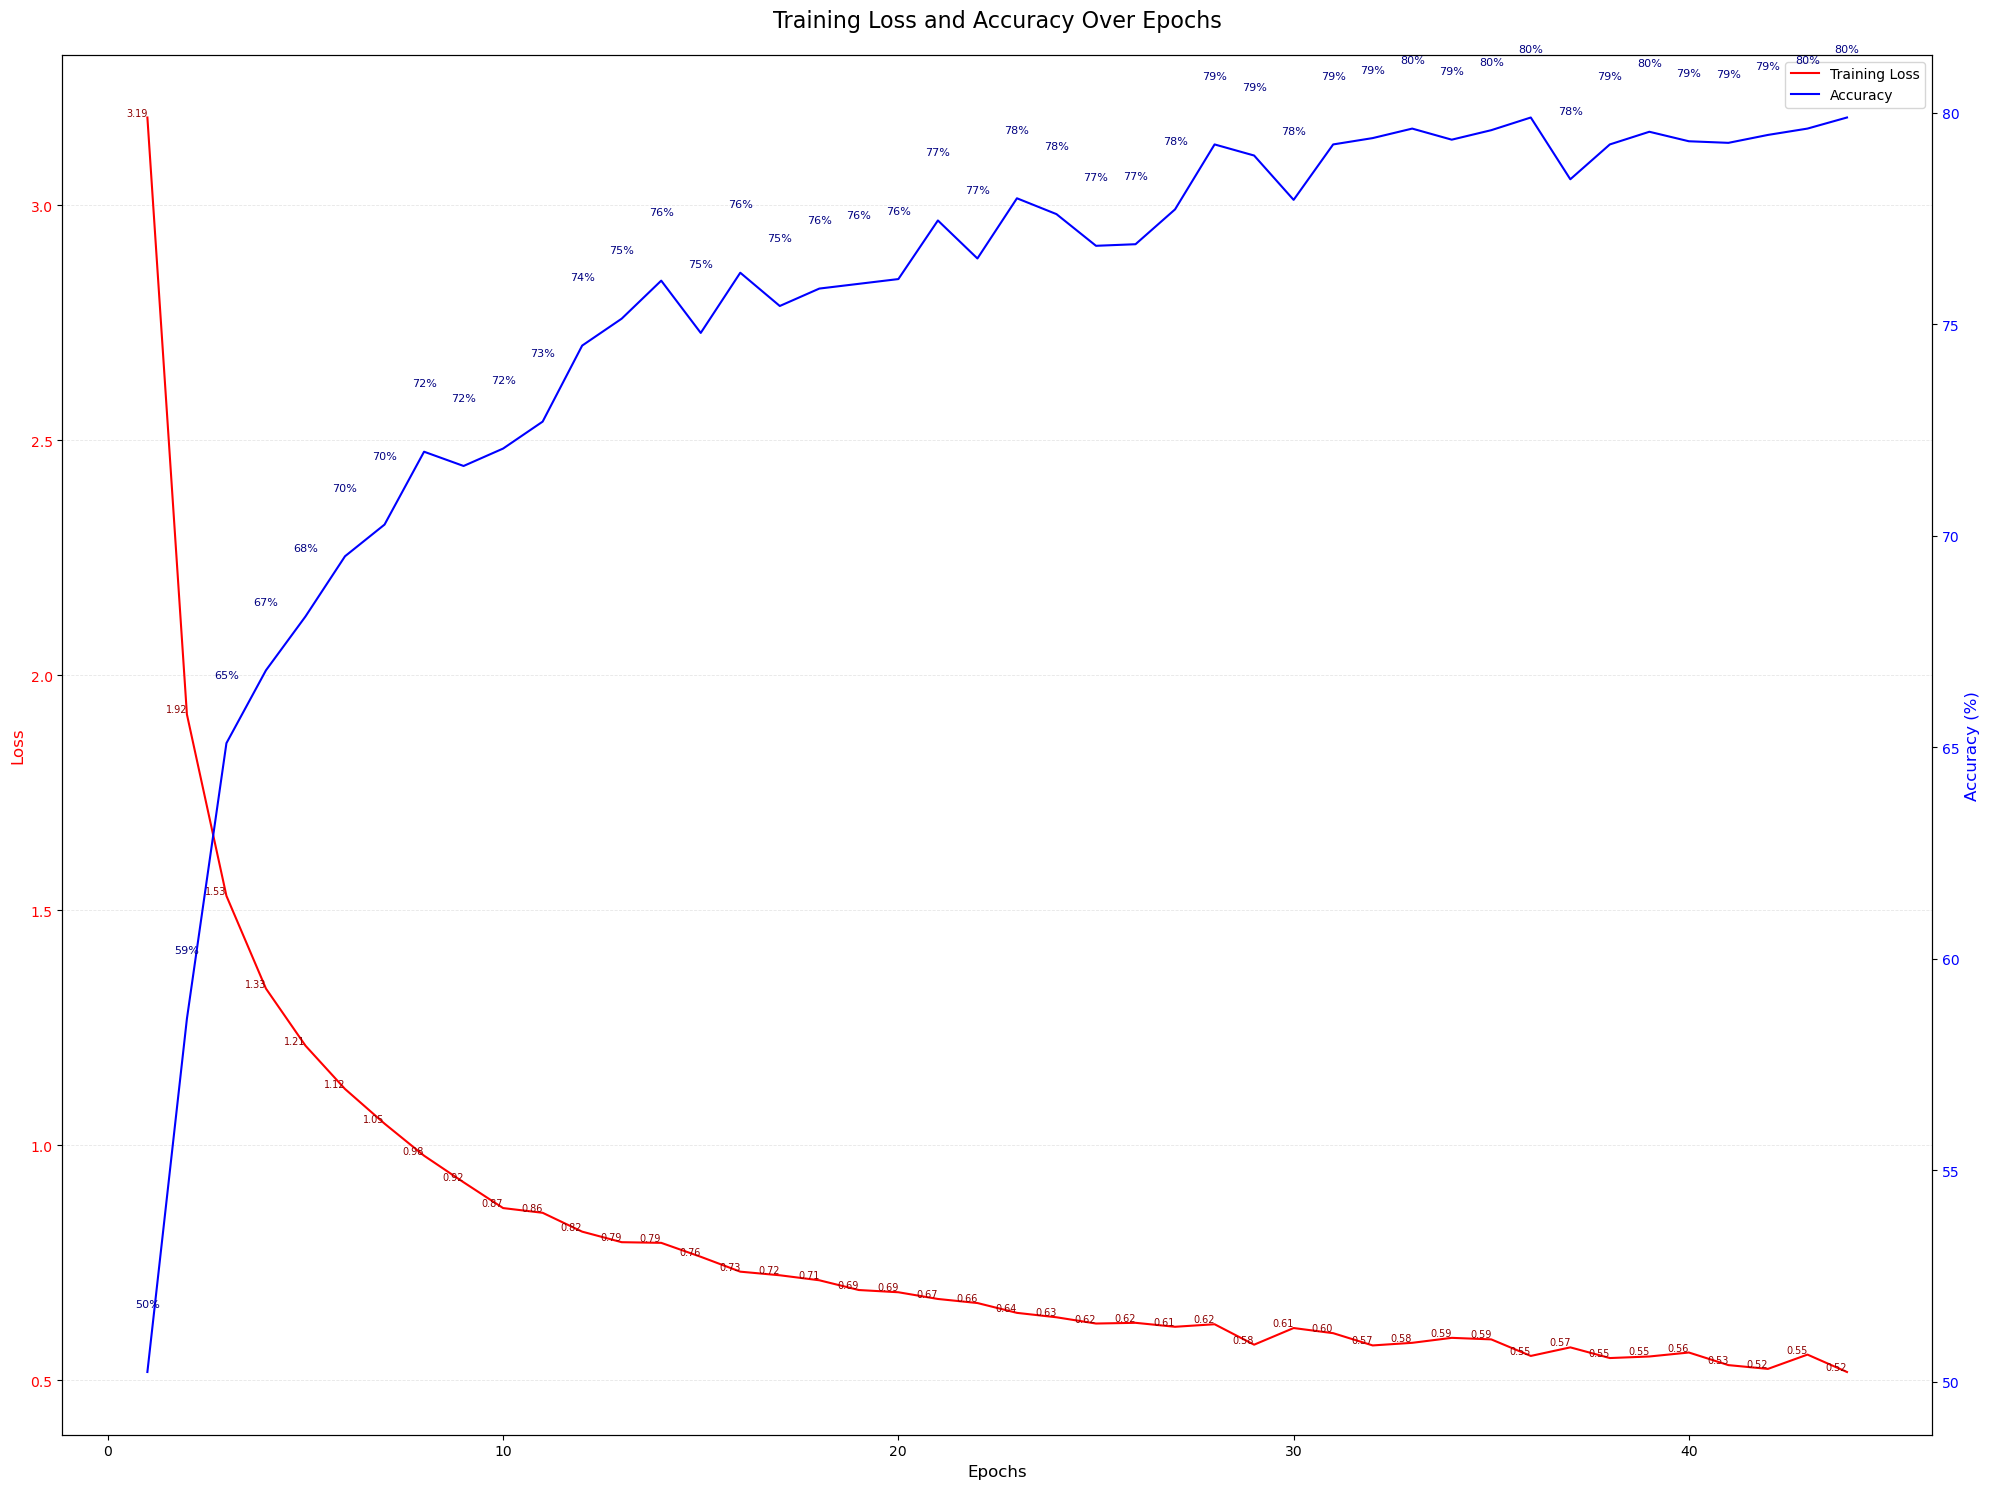

Allocated memory: 0.10 GB
Reserved memory: 0.13 GB -> 0.13 GB


In [47]:
fig, ax1 = plt.subplots(figsize=(20, 15))

epochs_range = range(1, len(train_losses) + 1)

# 🎯 Plot Loss
ax1.plot(epochs_range, train_losses, linestyle="-", label="Training Loss", color="red")
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("Loss", color="red", fontsize=12)
ax1.tick_params(axis="y", labelcolor="red")

# Добавление текста на график для Loss
for x, y in zip(epochs_range, train_losses):
    ax1.text(x, y, f"{y:.2f}", ha="right", va="bottom", fontsize=7, color="darkred")

# Пунктирная горизонтальная сетка
ax1.yaxis.grid(True, linestyle='--', linewidth=0.6, alpha=0.3)

# 🎯 Accuracy axis
ax2 = ax1.twinx()
ax2.plot(epochs_range, accuracies, linestyle="-", label="Accuracy", color="blue")
ax2.set_ylabel("Accuracy (%)", color="blue", fontsize=12)
ax2.tick_params(axis="y", labelcolor="blue")

# Более читаемые подписи для Accuracy
for x, y in zip(epochs_range, accuracies):
    ax2.text(x, y + 1.5, f"{y:.0f}%", ha="center", va="bottom", fontsize=8, color="navy")

# 🧩 Общий заголовок и легенда
plt.title("Training Loss and Accuracy Over Epochs", fontsize=16, pad=20)

# Легенды (от обеих осей)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=10)

send_plot(fig, "📉 Loss & Accuracy")
plt.tight_layout()
plt.show()
cleanup()


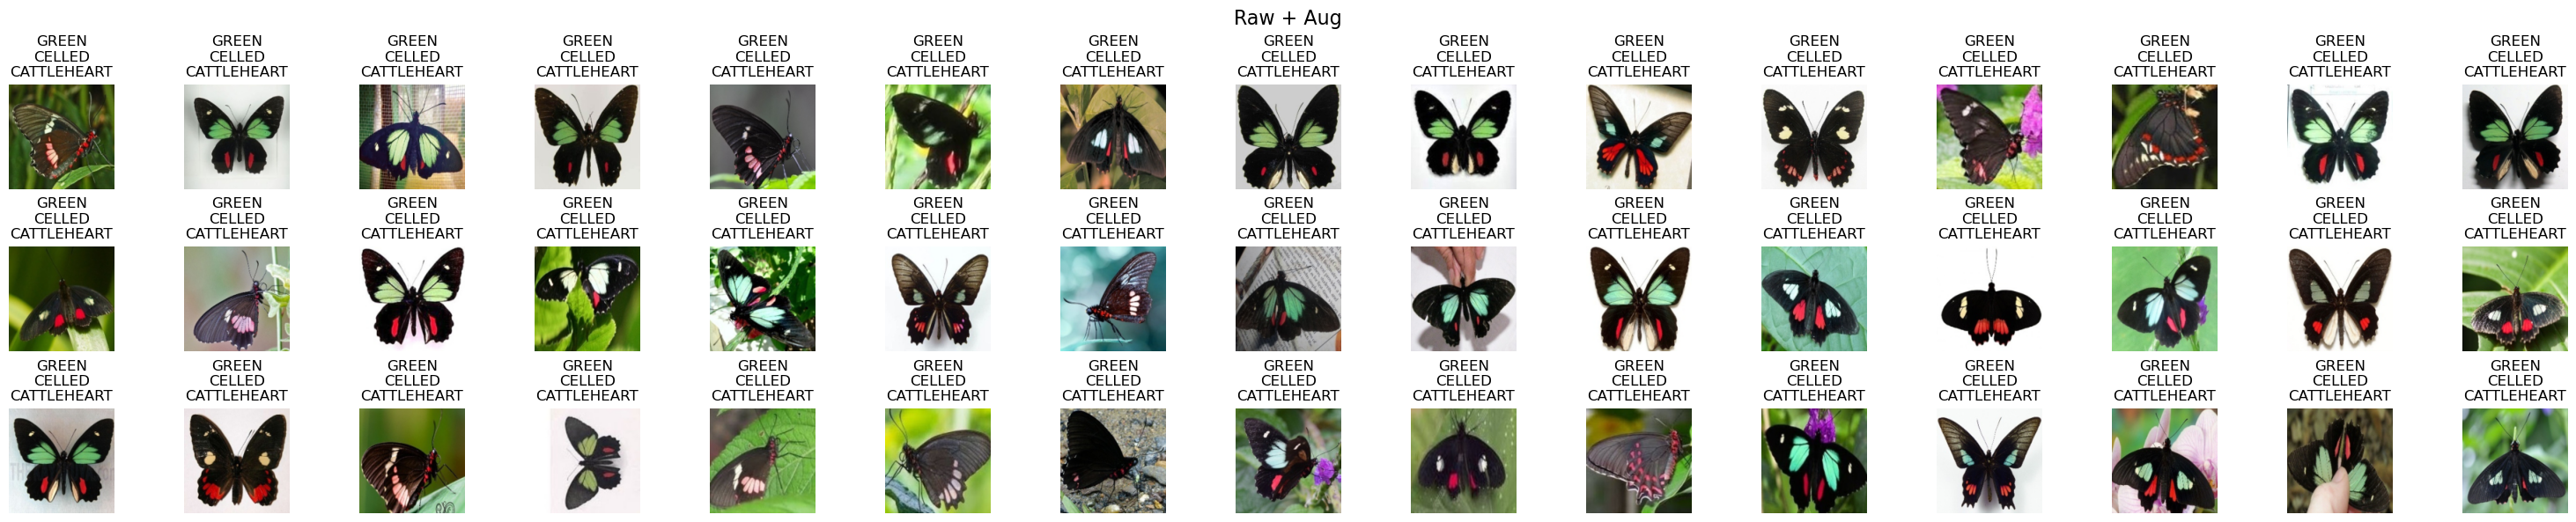

[telegram] ✅ sendPhoto.
Allocated memory: 0.10 GB
Reserved memory: 0.13 GB -> 0.13 GB


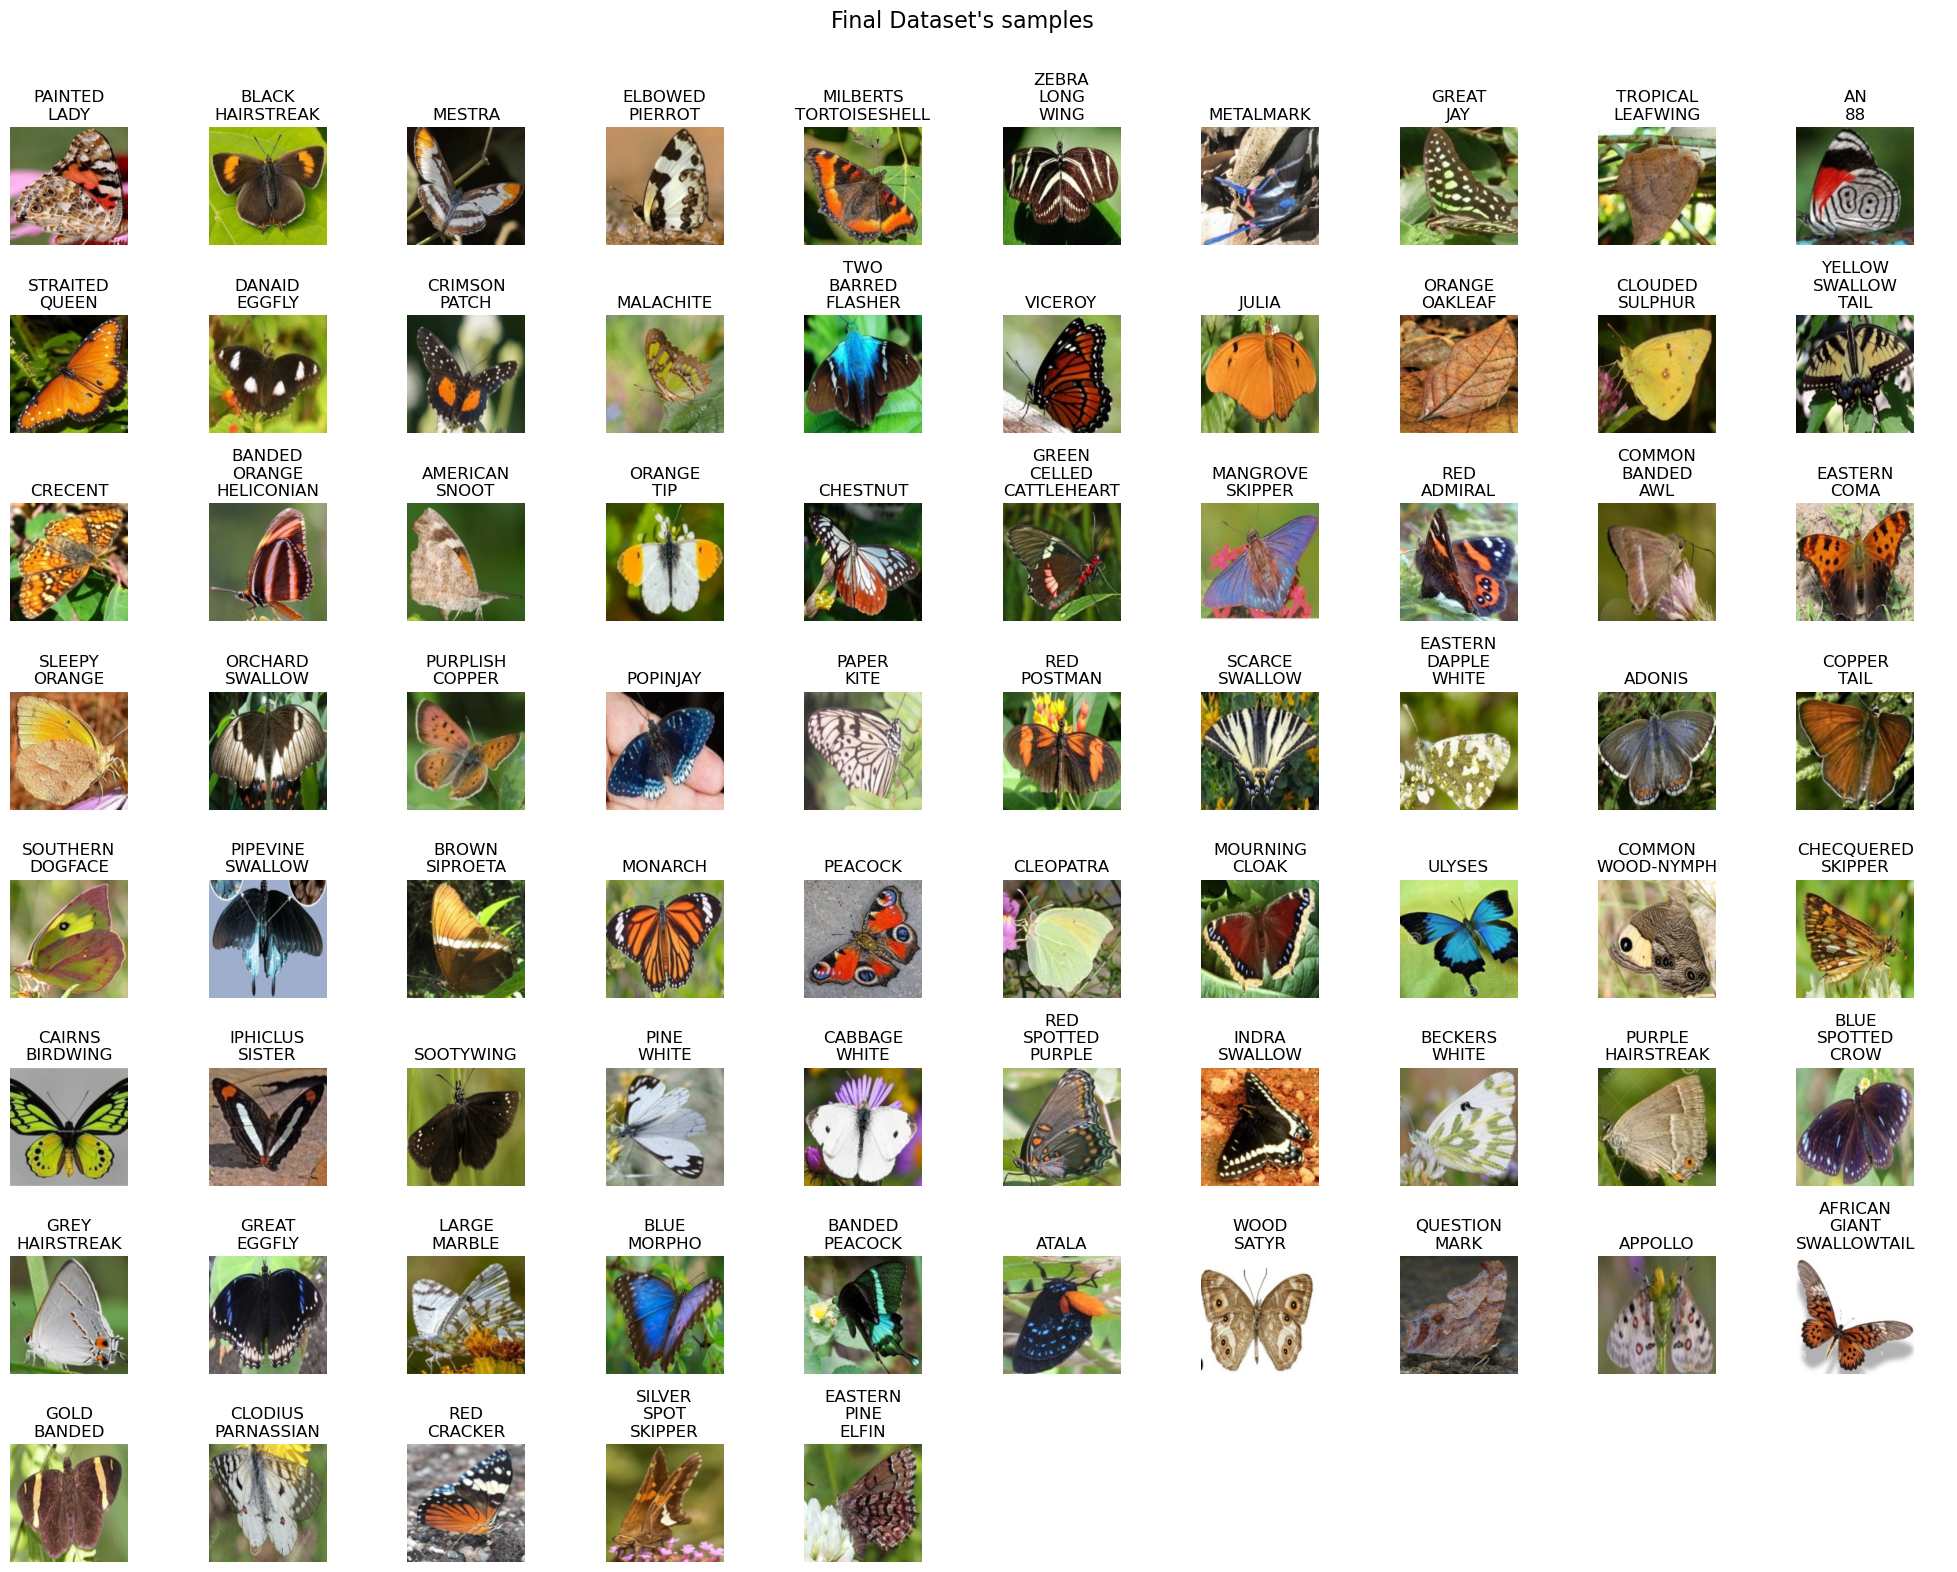

[telegram] ✅ sendPhoto.
Allocated memory: 0.10 GB
Reserved memory: 0.13 GB -> 0.13 GB


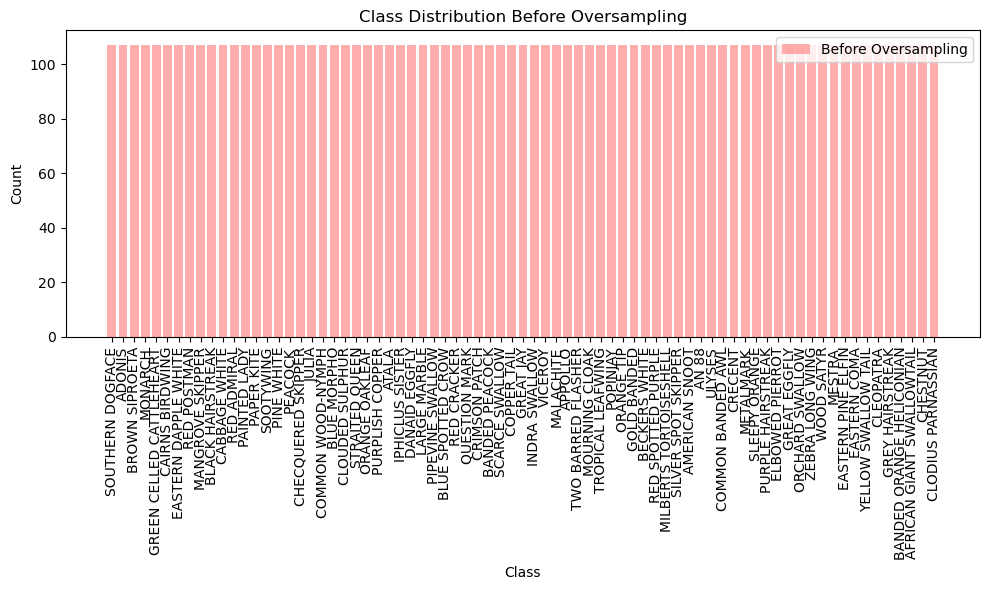

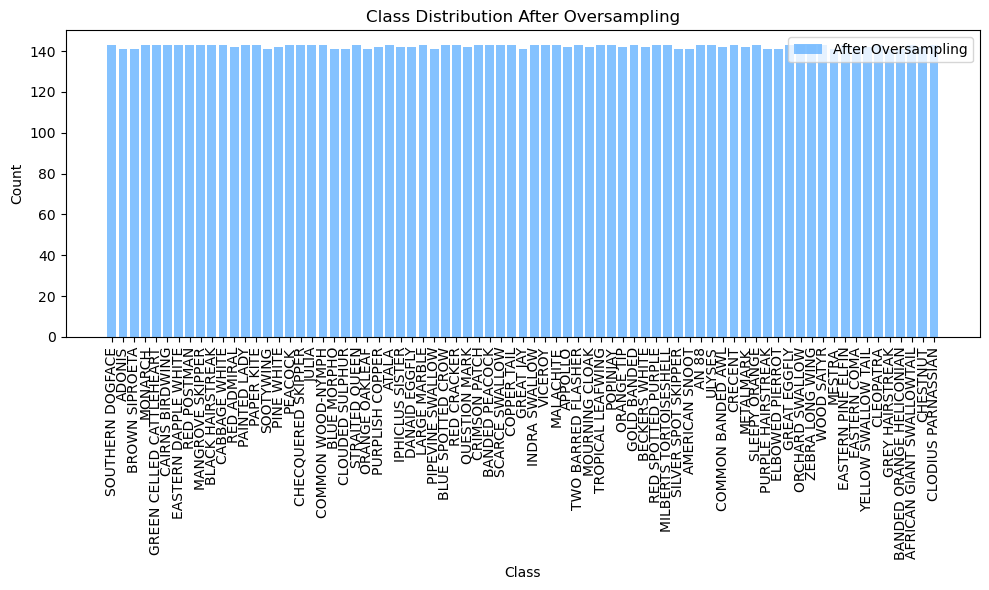

In [48]:
show_images(train_dataset, mode = "one_class", target_class_name="GREEN CELLED CATTLEHEART", ncols=15, plot_title="Raw + Aug")
show_images(train_dataset, plot_title="Final Dataset's samples")